In [155]:
import numpy as np
import matplotlib.pyplot as plt

In [156]:
class MultiClassKernelPerceptron():
    """
    A multiclass implementation of the kernel perceptron
    Designed for the MNIST dataset to classify digits 0-9
    """
        
    def __init__(self, kernel, num_digits):
        """
        Instantiates the perceptron instance

        Args:
            kernel: kernel function to use
            num_diits: number of digits to classify,
                assumes digits range from 0...num_digits
        """
        self.kernel = kernel
        self.num_classes = num_digits

    def train(self, X, Y):   
        """
        Trains the perceptron

        Args:
            X: training data (n x d)
            Y: training labels (n x 1)
        """
        num_epochs = 3
        X_size = X.shape[0]
        self.alpha = np.zeros((X_size, self.num_classes))
        self.X_training = X
        Y = Y.astype(int)

        # Instantiate once and reuse in update step
        label_vector = -1 * np.ones(self.num_classes)
        zeros = np.zeros(self.num_classes)

        # Calculate gram matrix
        self.gram_matrix = self.get_kernel_matrix(X, X)

        for epoch in range(num_epochs):
            for i in range(X_size):
                # Get decisions for all the classifiers
                decisions = np.sign(np.dot(self.alpha.T, self.gram_matrix[:, i]))

                # The label vector should be -1 for every index
                # except the one corresponding to the current Yi label
                label_vector[Y[i]] = 1

                # For a given classifier, if the decision * label <= 0,
                # the update is the label, otherwise it is zero
                update = np.where(decisions*label_vector <=0, label_vector, zeros)

                # Add the update to alpha, reset label vector
                self.alpha[i,:] += update
                label_vector[Y[i]] = -1
                
    def predict(self, X):
        """
        Predicts the labels of a new set of data

        Args:
            X: data to classify
        """
        k_matrix = self.get_kernel_matrix(X, self.X_training)

        # See how confident each classifier is that the training point is the given class
        # This corresponds to distance from the classifier's decision boundary
        data_confidence_by_classifier = np.array(
            [ np.dot(self.alpha[:, classifier], k_matrix) 
                for classifier in range(self.num_classes)])
        
        # Pick the label of the classifier with the max confidence
        predictions = np.array([np.argmax(data) for data in data_confidence_by_classifier.T])
        return predictions
    
    def get_kernel_matrix(self, X1, X2):
        """
        Calculates the full kernel matrix between X1 and X2
        using the perceptron's kernel function

        Args:
            X1, X2: (ax1) and (bx1) vectors
        Returns:
            axb matrix of kernel distances
        """
        return np.array([[
            self.kernel(X1[i], X2[j])
                for i in range(X1.shape[0])] 
                for j in range(X2.shape[0])])
    
###### HELPER FUNCTIONS #####
def split_data(data, split_fraction):
    """
    Splits the data into two sets with the specified fraction.

    Args:
        data: numpy matrix of data
        split_fraction: fraction to split
    Returns:
        larger dataset, smaller dataset
    """
    num_data = data.shape[0]
    np.random.shuffle(data)
    split_index = int(num_data - num_data * split_fraction)

    return data[:split_index], data[split_index:]

def get_polynomial_kernel(degree):
    """
    Returns a polynomial kernel with specified degree

    Args:
        degree: degree of polynomial
    Returns:
        polynomial kernel function
    """

    def polynomial_kernel(x1, x2):
        return (np.dot(x1, x2)) ** degree
    
    return polynomial_kernel

In [157]:
# Load data into numpy
data = np.genfromtxt('./dtest123.dat')

# Adjust data labels to start from 0
data[:,0] -= 1
training, validation = split_data(data, 0.8)

degree = 3
num_classes = len(np.unique(data[:,0]))
kperceptron = MultiClassKernelPerceptron(get_polynomial_kernel(degree), num_classes)

train_X = training[:,1:]
train_Y = training[:,0]
kperceptron.train(train_X, train_Y)

In [159]:
valid_X = validation[:,1:]
valid_Y = validation[:,0].astype(int)

predictions = kperceptron.predict(valid_X)
# print("predictions:", predictions)

num_correct = (predictions == valid_Y).sum()
ratio = num_correct / valid_X.shape[0]
print("Num correct", num_correct)
print("Ratio", ratio)

predictions: [1 0 0 1 0 1 2 0 1 0 1 0 1 2 2 0 0 2 0 2 2 2 1 0 1 0 1 2 2 0 0 1 2 0 2 1 0
 0 2 2 0 0 1 1 0 2 0 0 1 1 0 2 2 1 0 0 1 1 2 0 0 1 0 1 1 0 0 2 0 0 2 0 2 2
 0 2 2 1 1 0 1 1 1 1 2 1 1 2 0 1 0 1 2 2 2 0 1 0 1 2 1 0 2 1 2 2 0 0 1 1 0
 1 1 0 1 0 1 2 2 1 0 0 1 0 0 0 1 2 2 1 0 2 2 1 0 0 1 0 1 2 0 2 1 0 0 2 1 2
 0 0 0 1 0 2 0 2 0 0 2 0 0 2 0 0 0 1 0 1 0 0 0 2 2 0 0 0 2 1 1 0 2 2 0 2 0
 2 2 2 0 1 2 1 0 2 0 2 2 0 0 2 1 1 0 0 2 0 2 1 1 0 1 1 2 2 1 1 2 0 0 1 0 0
 2 2 0 1 0 2 0 2 0 1 2 2 1 1 2 2 0 0 0 0 1 0 1 2 2 1 0 1 2 1 1 2 1 2 1 2 2
 0 0 1 2 0 2 2 0 1 0 0 1 2 2 2 0 2 1 0 2 0 1 1 2 0 1 2 2 2 0 1 0 1 2 0 2 2
 2 0 0 0 0 0 2 2 0 0 2 0 0 1 2 1 1 0 0 2 1 2 1 1 2 0 2 1 0 0 1 0 2 2 0 2 0
 0 0 2 0 0 2 1 0 0 0 2 1 0 2 1 0 0 2 2 0 1 2 0 0 2 0 0 0 2 0 2 2]
Num correct 340
Ratio 0.9315068493150684


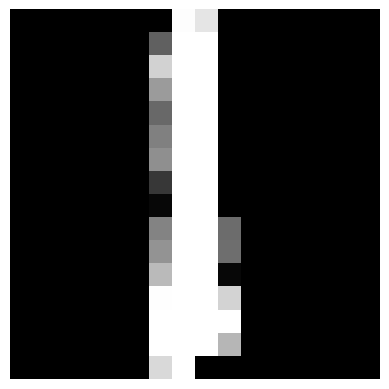

In [137]:
def visualize_params(params):
    plt.figure()
    plt.imshow(np.reshape(params, (16,16)),
                interpolation="None",
                cmap='gray',
                vmin=0, 
                vmax=1)
    plt.axis('off')
    plt.show()

visualize_params(data[6,1:])


In [138]:
data1 = np.genfromtxt('./zipcombo.dat')


In [142]:
data1.shape
np.unique(data1[:,0])

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])